## Laboratorium 3.4 Implementacja NEAT
## [Zadanie](https://pages.mini.pw.edu.pl/~karwowskij/mioad/lab-gen.html)
Z racji tego, że neat jest skomplikowanym podejściem, jego implementacja rozbita jest na dwa tygodnie. W ramach pierwszego deadline należy przesłać niekoniecznie kompletny i działający kod, który będzie dowodem rozpoczęcia pracy nad rozwiązaniem. Dopiero kod w kolejnym tygodniu musi w pełni działać.

W tym tygodniu trzeba zaimplementować: kodowanie, w szczególności generowanie fenotypu z genotypu, wyliczanie funkcji dopasowania i część operatora mutacji polegająca na dodaniu neuronu i zmianie wagi.

W ramach testu przeprowadzić próbne uczenie (bez krzyżowania) na zbiorze easy z laboratorium o sieciach neuronowych.


In [1]:
import math
import random
import statistics
import numpy as np
import pandas as pd
from enum import Enum
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from itertools import groupby, chain

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10, 10)

In [2]:
class Activations:
    @staticmethod
    def linear(x):
        return x

    @staticmethod
    def sigmoid(x):
        return 1/(1+math.exp(-4.9*x))

In [3]:
class NodeType(Enum):
    """
    Set of symbolic names (members) bound to unique, constant values. 
    Within an enumeration, the members can be compared by identity, 
    and the enumeration itself can be iterated over
    """
    INPUT_LAYER = 1
    BIAS = 2
    HIDDEN_LAYER = 3
    OUTPUT_LAYER = 4

    def __gt__(self, other):
        return self.value > other.value

In [4]:
class Node(object):
    def __init__(self, id, type, activation = Activations.linear, value = 0.0, depth = 0.0):
        
        assert isinstance(type, NodeType)
        
        self.id = id
        self.type = type
        self.activation = activation
        self.value = value
        self.depth = depth
        self.visited = False

        self.inputs = []

    def __hash__(self):
        return hash(f'{self.id}:{self.type}')

    def __eq__(self, other):
        if isinstance(other, Node):
            return self.id == other.id
        else:
            raise ValueError(f'Invalid value type - should be Node, got {type(other)}')

    def __add__(self, other):
        if isinstance(other, Node):
            return self.id + other.id
        elif isinstance(other, int):
            return self.id + other
        else:
            raise ValueError(f'Invalid value type - should be Node or int, got {type(other)}')

In [5]:
def group_nodes_by_type(nodes):
    sorted_nodes = sorted(nodes, key = lambda x: x.type)
    grouped_nodes = [list(it) for k, it in groupby(sorted_nodes, lambda x: x.type)]
    return grouped_nodes

def group_nodes_by_depth(nodes):
    sorted_nodes = sorted(nodes, key = lambda x: x.depth)
    grouped_nodes = [list(it) for k, it in groupby(sorted_nodes, lambda x: x.depth)]
    return grouped_nodes

In [6]:
class Connection(object):
    connections = {}
    global_innovation = 0

    def __init__(self, in_node, out_node, weight = 1.0, dummy = False):
        self.in_node = in_node
        self.out_node = out_node
        self.enabled = True
        self.dummy = dummy
        if dummy: return
        self.weight = weight
        self.innovation = Connection.register_connection(self)

        self.out_node.inputs.append(self)

    def __gt__(self, other):
        return self.innovation > other.innovation

    @classmethod
    def register_connection(cls, new_connection):
        if new_connection in cls.connections:
            return cls.connections[new_connection]
        else:
            cls.global_innovation += 1
            cls.connections[new_connection] = cls.global_innovation
            return cls.global_innovation

    def __hash__(self):
        return hash(str(self.in_node.id)+str(self.out_node.id))

    def __eq__(self, other):
        if isinstance(other, Connection):
            return ((self.in_node == other.in_node) and
                    (self.out_node == other.out_node))
        else:
            raise ValueError(f'Value type should be Connection, got {type(other)}')


    def copy(self):
        return copy.deepcopy(self)

    def __str__(self):
        string = f'{self.in_node.id} -> {self.out_node.id} '
        string = f'{string}Weight: {self.weight:.3f} '
        if self.dummy:
            string = f'{string}Innovation No: Dummy '
        else:
            string = f'{string}Innovation No: {self.innovation} '
        string = f'{string}Disabled: {not self.enabled} '
        return string

In [7]:
def align_connections(connections_1, connections_2):
    dummy_node = Node(0, NodeType.HIDDEN_LAYER)
    dummy_connection = Connection(dummy_node, dummy_node, dummy=True)
    end = dummy_connection
    iterators = [chain(i, [end]) for i in [sorted(connections_1),
        sorted(connections_2)]]
    values = [next(i) for i in iterators]
    connections_1 = []
    connections_2 = []
    weights = []
    excess = 0
    disjoint = 0
    while not all(v is end for v in values):
        smallest = min(v for v in values if v is not end)
        alignment = []
        match = True
        for v in values:
            if v == smallest:
                alignment.append(v)
            else:
                match = False
                alignment.append(dummy_connection)
                if values[0] is end or values[1] is end:
                    excess += 1
                else:
                    disjoint += 1
        connection_1, connection_2 = alignment
        if match:
            weights.append(abs(connection_1.weight - connection_2.weight))
        connections_1.append(connection_1)
        connections_2.append(connection_2)
        values = [next(i) if v == smallest else v
                  for i, v in zip(iterators, values)]
    avarage_weight_difference = statistics.mean(weights)
    return connections_1, connections_2, disjoint, excess, avarage_weight_difference

In [8]:
class Genome(object):
    def __init__(self, nodes, connections):
        self.connections = connections
        self.nodes = nodes

        grouped_nodes = group_nodes_by_type(self.nodes)
        self.input_size = len(grouped_nodes[0])
        self.output_size = len(grouped_nodes[-1])
        self.outputs = grouped_nodes[-1]

    def weight_mutation(self, magnitude, random_range):
        '''Apply weight mutation to connection weights.'''
        for connection in self.connections:
            if random.random() <= 0.1:
                connection.weight = random.uniform(*random_range)
            else:
                connection.weight += random.uniform(-magnitude, magnitude)

    def add_connection_mutation(self, random_range):
        '''Create new connection between two random non-connected nodes.'''
        def _add_connection_mutation(depth = 0):
            in_idx = random.randint(0, len(self.nodes)-1)
            in_node = self.nodes[in_idx]
            out_idx = random.randint(0, len(self.nodes)-1)
            out_node = self.nodes[out_idx]
            connection = Connection(in_node, out_node, dummy=True)
            if (connection in self.connections or out_node.type == NodeType.BIAS or 
                out_node.type == NodeType.INPUT_LAYER or in_node.type == NodeType.OUTPUT_LAYER):
                if depth > 20:
                    return
                _add_connection_mutation(depth+1)
                return
            connection = Connection(in_node, out_node, random.uniform(*random_range))
            self.connections.append(connection)
        _add_connection_mutation()

    def add_node_mutation(self, activation = lambda x: x):
        '''Add a node to a random connection and split the connection.'''
        idx = random.randint(0, len(self.connections)-1)
        self.connections[idx].enabled = False
        new_node = Node(max(self.nodes, key=lambda x: x.id)+1,
                        NodeType.HIDDEN_LAYER, activation)
        first_connection = Connection(self.connections[idx].in_node, new_node, 1)
        weight = self.connections[idx].weight
        second_connection = Connection(new_node, self.connections[idx].out_node, weight)
        self.connections.append(first_connection)
        self.connections.append(second_connection)
        new_node.depth = (first_connection.in_node.depth +
                          second_connection.out_node.depth) / 2
        self.nodes.append(new_node)

    def __call__(self, inputs):
        self.nodes.sort(key=lambda x: x.depth)
        for node in self.nodes:
            value = 0.0
            if node.type == NodeType.INPUT_LAYER:
                value += inputs[node.id]
            elif node.type == NodeType.BIAS:
                continue
            for connection in node.inputs:
                if connection.enabled:
                    value += connection.in_node.value * connection.weight
            node.value = node.activation(value)
        return [node.value for node in self.outputs]

    @property
    def size(self):
        return len(list(filter(lambda x: x.enabled, self.connections)))

    def crossover(self, other: 'Genome'):
        '''Crossover the genome with the other genome.'''
        return crossover(self, other)

    def draw(self, node_radius = 0.05, vertical_distance = 0.25, horizontal_distance = 0.25):
        draw_genome(self, node_radius, vertical_distance, horizontal_distance)

    def distance(self, other, c1, c2, c3):
        return distance(self, other, c1, c2, c3)

In [9]:
def distance(genome_1, genome_2, c1, c2, c3):
    N = max(genome_1.size, genome_2.size)
    _, _, disjoint, excess, avarage_weight_difference = align_connections(
        genome_1.connections, genome_2.connections)
    return excess*c1/N + disjoint*c2/N + avarage_weight_difference*c3

def crossover(genome_1, genome_2, disable_rate = 0.75):
    '''Crossover two genomes by aligning their innovation numbers.'''
    connections = []
    nodes = []
    connections_1, connections_2, _, _, _ = align_connections(
        genome_1.connections, genome_2.connections)

    for idx in range(len(connections_1)):
        connection_1 = connections_1[idx]
        connection_2 = connections_2[idx]
        if connection_1.dummy:
            connection = connection_2
        elif connection_2.dummy:
            connection = connection_1
        else:
            connection = random.choice([connection_1, connection_2])

        in_node = Node(connection.in_node.id, connection.in_node.type,
                       connection.in_node.activation,
                       depth = connection.in_node.depth)
        out_node = Node(connection.out_node.id, connection.out_node.type,
                        connection.out_node.activation,
                        depth = connection.out_node.depth)
                
        nodes_dict = dict(zip(nodes, range(len(nodes))))
        if in_node not in nodes_dict:
            nodes.append(in_node)
            nodes_dict[in_node] = len(nodes)-1
        if out_node not in nodes_dict:
            nodes.append(out_node)
            nodes_dict[out_node] = len(nodes)-1
        connection = Connection(nodes[nodes_dict[in_node]],
                                nodes[nodes_dict[out_node]],
                                connection.weight)
        if connection_1.enabled and connection_2.enabled:
            connection.enabled = True
        elif connection_1.enabled ^ connection_2.enabled:
            connection.enabled = random.random() > disable_rate
        else:
            connection.enabled = False
        connections.append(connection)
    new_genome = Genome(nodes, connections)
    return new_genome

def draw_genome(genome, node_radius = 0.05, vertical_distance = 0.25, horizontal_distance = 0.25):
    '''Draw the genome to a matplotlib figure but do not show it.'''
    plt.gcf().canvas.set_window_title('float')

    positions = {}
    node_groups = group_nodes_by_depth(genome.nodes)
    for group_idx, nodes in enumerate(node_groups):
        y_position = -vertical_distance * (len(nodes)-1)/2
        for i, node in enumerate(nodes):
            positions[f'{node.id}'] = (group_idx * horizontal_distance,
                                       y_position + i*vertical_distance)
            circle = plt.Circle(positions[f'{node.id}'],
                                node_radius, color='r', fill=False)
            plt.gcf().gca().text(*positions[f'{node.id}'], node.id,
                                 horizontalalignment='center',
                                 verticalalignment='center',
                                 fontsize=10.0)
            plt.gcf().gca().add_artist(circle)

    for connection in genome.connections:
        if connection.enabled:
            node1_x = positions[f'{connection.in_node.id}'][0]
            node2_x = positions[f'{connection.out_node.id}'][0]
            node1_y = positions[f'{connection.in_node.id}'][1]
            node2_y = positions[f'{connection.out_node.id}'][1]
            angle = math.atan2(node2_x - node1_x, node2_y - node1_y)
            x_adjustment = node_radius * math.sin(angle)
            y_adjustment = node_radius * math.cos(angle)
            arrow = patches.FancyArrowPatch(
                (node1_x + x_adjustment,
                 node1_y + y_adjustment),
                (node2_x - x_adjustment,
                 node2_y - y_adjustment),
                arrowstyle="Simple,tail_width=0.5,head_width=3,head_length=5",
                color="k", antialiased=True)
            plt.gcf().gca().add_patch(arrow)
    plt.axis('scaled')

In [10]:
class ContextGenome(Genome):
    '''Genome class that holds data which depends on the context.'''
    def __init__(self, nodes, connections):
        self.species: Species
        self.fitness: float = 0.0
        self.generation: int = 0
        super().__init__(nodes, connections)

    def crossover(self, other):
        new_genome = super(ContextGenome, self).crossover(other)
        return ContextGenome(new_genome.nodes, new_genome.connections)


class Species(object):
    id: int = 0
    def __init__(self, representer):
        self.genomes = [representer]
        self.representer = representer
        self.species_id = Species.assign_id()
        self.max_fitness = representer.fitness
        self.improved_generation = 0
        self.total_adjusted_fitness = 0.0
        self.stegnant = 0

    def add_genome(self, genome) -> None:
        self.genomes.append(genome)
        if genome.fitness > self.max_fitness:
            self.stegnant = 0
            self.improved_generation = genome.generation
            self.max_fitness = genome.fitness
        else:
            self.stegnant = genome.generation - self.improved_generation

    def reset(self) -> None:
        self.total_adjusted_fitness = 0.0
        self.representer = random.choice(self.genomes)
        self.genomes = []

    @classmethod
    def assign_id(cls):
        cls.id += 1
        return cls.id
    
    def __gt__(self, other):
        return self.id > other.id

In [11]:
class NEAT(object):
    def __init__(self, n_networks, input_size, output_size, bias, c1, c2, c3, distance_threshold, 
                 weight_mutation_rate, node_mutation_rate, connection_mutation_rate, interspecies_mating_rate,
                 disable_rate = 0.75, stegnant_threshold = 15, random_range = (-1.0, 1.0), noise_magnitude = 0.001,
                 input_activation=Activations.sigmoid, hidden_activation=Activations.sigmoid, output_activation=Activations.sigmoid):

        self.n_networks = n_networks
        self.input_size = input_size
        self.output_size = output_size
        self.bias = bias
        self.c1, self.c2, self.c3 = c1, c2, c3
        self.random_range = random_range
        self.noise_magnitude = noise_magnitude
        self.distance_threshold = distance_threshold
        self.disable_rate = disable_rate
        self.weight_mutation_rate = weight_mutation_rate
        self.interspecies_mating_rate = interspecies_mating_rate
        self.node_mutation_rate = node_mutation_rate
        self.connection_mutation_rate = connection_mutation_rate
        self.stegnant_threshold = stegnant_threshold
        self.input_activation = input_activation
        self.hidden_activation = hidden_activation
        self.output_activation = output_activation

        self.generation = 0
        self.best_fitness: float = -float('inf')
        self.best_genome: ContextGenome

        self.create_population()
        self.species = [Species(random.choice(self.population))]
        self.update_species()
        
    def __gt__(self, other):
        return self.id > other.id

    def random_genome(self):
        '''Create fc neural network without hidden layers with random weights.'''
        connections = []
        input_nodes = [Node(i, NodeType.INPUT_LAYER, self.input_activation,
                            depth = 0.0)
                       for i in range(self.input_size)]
        if self.bias:
            input_nodes.append(Node(self.input_size, NodeType.BIAS, value = 1.0,
                                    depth = 0.0))
        output_nodes = [Node(i+len(input_nodes), NodeType.OUTPUT_LAYER,
                             self.output_activation, depth = 1.0)
                        for i in range(self.output_size)]
        for i in range(len(input_nodes)):
            input_node = input_nodes[i]
            for j in range(self.output_size):
                output_node = output_nodes[j]
                connections += [Connection(input_node, output_node,
                                           random.uniform(*self.random_range))]
        return ContextGenome(input_nodes+output_nodes, connections)
                             

    def create_population(self):
        population = []
        for _ in range(self.n_networks):
            population.append(self.random_genome())
        self.population = population

    def update_species(self):
        for species in self.species:
            species.reset()

        for genome in self.population:
            known = False
            for species in self.species:
                if genome.distance(
                        species.representer,
                        self.c1, self.c2, self.c3) < self.distance_threshold:
                    species.add_genome(genome)
                    genome.species = species
                    known = True
                    break
            if not known: 
                new_species = Species(genome)
                self.species.append(new_species)
                genome.species = new_species

    def next_generation(self, rewards):
        for idx, reward in enumerate(rewards):
            self.population[idx].fitness = reward
            if reward > self.best_fitness:
                self.best_fitness = reward
                self.best_genome = self.population[idx]

        self.update_species()

        # Remove the worst from each species and delete empty species
        for idx in reversed(range(len(self.species))):
            species = self.species[idx]
            if len(species.genomes):
                # Species are sorted by fitness scores in reverse
                species.genomes.sort(key = lambda x: x.fitness, reverse=True)
                species.genomes.pop()
            if not len(species.genomes):
                self.species.pop(idx)

        self.adjust_fitness_scores()

        population = []

        sorted_population = sorted(
            self.population, key = lambda x: x.species.species_id)
        grouped_population = [list(it) for k, it in groupby(
            sorted_population, lambda x: x.species.species_id)]

        # Preserve champions in the species
        self.generation += 1
        for group in grouped_population:
            if len(group) > 5:
                best_genome = max(group, key = lambda x: x.fitness)
                best_genome.generation = self.generation
                population.append(best_genome)

        while len(population) < self.n_networks:
            species = self.get_random_species()
            genome_1 = self.get_random_genome(species)
            if random.random() < self.interspecies_mating_rate:
                species = self.get_random_species()
            genome_2 = self.get_random_genome(species)
            new_genome = genome_1.crossover(genome_2)
            if random.random() < self.weight_mutation_rate:
                new_genome.weight_mutation(self.noise_magnitude, self.random_range)
            if random.random() < self.node_mutation_rate:
                new_genome.add_node_mutation(activation = self.hidden_activation)
            if random.random() < self.connection_mutation_rate:
                new_genome.add_connection_mutation(self.random_range)
            new_genome.generation = self.generation
            population.append(new_genome)

        self.population = population

    def adjust_fitness_scores(self):
        for species in self.species:
            for genome in species.genomes:
                genome.fitness = genome.fitness / len(species.genomes)
                species.total_adjusted_fitness += genome.fitness

    def get_random_species(self):
        if len(self.species) == 1:
            return self.species[0]
        total = 0.0
        length = 0
        min_fitness = float('inf')
        for species in self.species:
            if species.stegnant < self.stegnant_threshold:
                length += 1
                total += species.total_adjusted_fitness
                if species.total_adjusted_fitness < min_fitness:
                    min_fitness = species.total_adjusted_fitness
        total += length * (-min_fitness + 0.1)
        r = random.random()
        upto = 0.0
        for species in self.species:
            if species.stegnant < self.stegnant_threshold:
                score = (species.total_adjusted_fitness - min_fitness + 0.1) / total
                upto += score
                if upto >= r:
                    return species
        assert False

    @staticmethod
    def get_random_genome(species):
        if len(species.genomes) == 1:
            return species.genomes[0]
        # Assume genomes are sorted by fitness, max first
        min_fitness = species.genomes[-1].fitness
        total = species.total_adjusted_fitness
        total += len(species.genomes) * (-min_fitness + 0.1)
        r = random.random()
        upto = 0.0
        for genome in species.genomes:
            score = (genome.fitness - min_fitness + 0.1) / total
            upto += score
            if upto >= r:
                return genome
        assert False

In [12]:
xor = NEAT(n_networks = 150,
            input_size = 2,
            output_size = 1,
            bias = True,
            c1 = 1.0, c2 = 1.0, c3 = 0.4,
            distance_threshold = 3.0,
            weight_mutation_rate = 0.8,
            node_mutation_rate = 0.03,
            connection_mutation_rate = 0.05,
            interspecies_mating_rate = 0.001,
            disable_rate = 0.75,
            stegnant_threshold = 15,
            input_activation = Activations.sigmoid,
            hidden_activation = Activations.sigmoid,
            output_activation = Activations.sigmoid)

In [13]:
# Easy dataset
easy_train = pd.read_csv("../data/mio1/classification/easy-training.csv")

# data preprocessing
x_train = easy_train[["x", "y"]].to_numpy()

y_train = easy_train["c"] * 1
n_values = np.max(y_train) + 1
y_train = np.eye(n_values)[y_train.T]

Generation: 0
Generation: 1
Generation: 2
Generation: 3
Generation: 4
Generation: 5
Generation: 6
Generation: 7
Generation: 8
Generation: 9
Generation: 10
Generation: 11
Generation: 12
Generation: 13
Generation: 14
Generation: 15
Generation: 16
Generation: 17
Generation: 18
Generation: 19
Generation: 20
Generation: 21
Generation: 22
Generation: 23
Generation: 24
Generation: 25
Generation: 26
Generation: 27
Generation: 28
Generation: 29


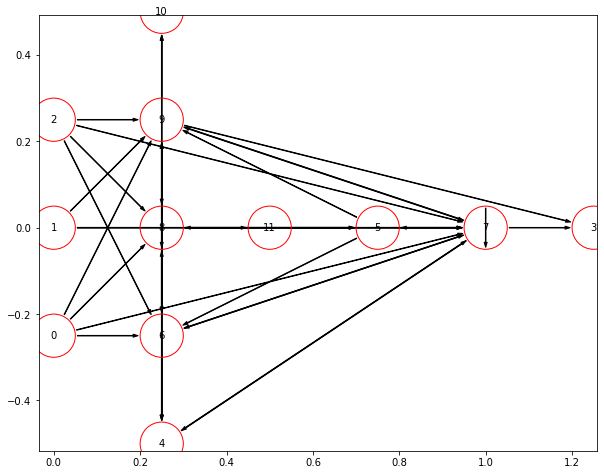

In [14]:
#truth_table = [[0, 1],[1, 0]]
solution_found = False
n_generations = 30

for i in range(n_generations):
    print(f'Generation: {xor.generation}')
    rewards = []
    for genome in xor.population:
        error = 0
        for row in range(len(y_train)):
            for col in range(len(y_train[0])):
                output = int(round(genome([row, col])[0]))
                error += abs(y_train[row][col] - output)
        rewards.append(error)
    xor.next_generation(rewards)

genome.draw()
plt.show()